<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [11]:
!pip install pygame
!pip install highway-env

Testing

In [12]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display



# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

%matplotlib inline

Environment Definition

In [13]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

IDM Controller

In [14]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs, desired_parameters, control_parameters):
    self.obs = obs
    # Unpack initial parameters: [s0, v0]
    self.s0, self.v0 = desired_parameters

    # Unpack control parameters: [a, b, delta, T]
    self.a, self.b, self.delta, self.T = control_parameters

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def update(self,obs):
    self.obs = obs

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
      # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
      ego_vehicle = env.unwrapped.vehicle
      lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]

      if lead_vehicle:
          gap = lead_vehicle.position[0] - ego_vehicle.position[0]
          delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
          self._longitudinal_lead_state = {"x": gap, "vx": delta_velocity}
      else:
          self._longitudinal_lead_state = {"x": 10, "vx": 0}

      return self._longitudinal_lead_state

  def idm_controller(self):
      # Unpack input variables: [s, v, delta_v]
      s, v, delta_v = self.longitudinal_lead_state()['x'], self.ego_state_idm()['vx'], self.longitudinal_lead_state()['vx']

      # Small epsilon to account for very small gaps and avoid division by zero
      epsilon = 1e-6

      # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
      desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

      # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
      acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

      return acceleration

  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = yaw acceleration (rate of change of yaw rate)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = yaw rate (rate of change of heading)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    # Use current vehicle lane structure and only change the lane ID
    current_lane_index = list(env.unwrapped.vehicle.lane_index)
    current_lane_index[2] = target_id  # Only change the lane number
    self.target_id = tuple(current_lane_index)

    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    # Extract lateral and longitudinal velocities from observations
    vx_current = obs[2]  # longitudinal velocity
    vy_current = obs[3]  # lateral velocity
    vx_old = obs_old[2]
    vy_old = obs_old[3]

    dt = 1.0 / env.unwrapped.config['policy_frequency']
    L = env.unwrapped.vehicle.LENGTH

    # Calculate both yaw rates in parallel using bicycle model
    vx_vals = np.array([vx_old, vx_current])
    vy_vals = np.array([vy_old, vy_current])

    # Vectorized calculations
    total_velocities = np.sqrt(vx_vals**2 + vy_vals**2)
    curvatures = np.divide(vy_vals, vx_vals * total_velocities + 1e-6,
                          out=np.zeros_like(vy_vals), where=(abs(vx_vals) > 1e-6))
    yaw_rates = total_velocities * curvatures

    previous_yaw_rate, current_yaw_rate = yaw_rates[0], yaw_rates[1]

    w_yaw = current_yaw_rate
    w_yaw_old = previous_yaw_rate

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  def action(self, obs, lateral_action):
      self.obs = obs
      L = env.unwrapped.vehicle.LENGTH
      self.acc = self.idm_controller()

      # Calculate steering angle from lateral acceleration
      self.angle = math.atan(L * lateral_action / self.ego_state_idm()['vx']**2)

      # Return the action as [longitudinal_acceleration, steering_angle]
      calculated_action = [self.acc, self.angle]

      return calculated_action

Agent Defintion

In [15]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=128):
        super().__init__()
        self.action_dim = action_dim

        # Policy head (actor) - Output 2 values: mean and log_std
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, self.action_dim * 2),  # Use self.action_dim here
        )

        # Value head (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Value head
        value = self.critic(x)

        # Policy head
        actor_output = self.actor(x)
        action_mean, action_log_std = torch.split(actor_output, self.action_dim, dim=-1) # Split output

        action_log_std = torch.clamp(action_log_std, -20, 2)
        action_std = torch.exp(action_log_std)
        action_dist = torch.distributions.Normal(action_mean, action_std)

        return action_dist, value

    def action(self, state, deterministic = False):
        action_dist, value = self.forward(state)

        if deterministic:
            action = action_dist.mean
            log_prob = action_dist.log_prob(action)

        else:
          action = action_dist.sample()
          log_prob = action_dist.log_prob(action)

        return action, log_prob, value

Lateral Controller (Gap Checker)

In [16]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Initialize Environment

In [17]:
# Initialize Environment
obs, _ = env.reset()
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Initialize Environment Manager and Reward
state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

Training Loop

In [18]:
################################################################################
"""Initialization"""
################################################################################
# Agent Initialization
total_steps_taken = 0

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)
action_dim = 1
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 1


Model

Plotting

In [19]:
def animate_image_list_efficient(image_list):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create initial image
    im = ax.imshow(image_list[0])
    ax.axis('off')
    title = ax.set_title('Frame 0')

    def animate(frame):
        # Just update the image data - more efficient
        im.set_array(image_list[frame])
        title.set_text(f'Frame {frame}/{len(image_list)}')
        return [im, title]

    anim = FuncAnimation(fig, animate, frames=len(image_list),
                        interval=100, blit=True, repeat=True)
    plt.close()
    return HTML(anim.to_jshtml())

# Initialize plot outside the loop (before the training loop starts)
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Hyperparameters

In [20]:
# Define hyperparameters
max_timesteps_per_rollout = 500  # Max timesteps per rollout
K = 10    # Number of policy update epochs
test_rate = 5  # Test every 5 batches
num_test = 0
rollout_size = 20

batch_size = 128
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
epsilon = 0.2
gae_lambda = 0.99
actor_lr = 3e-4  # Reduced learning rate
critic_lr = 1e-3

# Episode counter
max_episodes_per_rollout = 1
nb_episodes = 1000
nb_batches = round(nb_episodes/max_episodes_per_rollout)

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
actor_params = list(model.actor.parameters())
critic_params = list(model.critic.parameters())

actor_optimizer = torch.optim.Adam(actor_params, lr=actor_lr)
critic_optimizer = torch.optim.Adam(critic_params, lr=critic_lr)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

Training Loop

  0%|          | 0/1000 [00:00<?, ?it/s]

Training Batch 1: Collected 269 timesteps Episode Count: 20


  0%|          | 1/1000 [00:10<2:57:51, 10.68s/it]

Training Batch 2: Collected 299 timesteps Episode Count: 20


  0%|          | 2/1000 [00:22<3:09:00, 11.36s/it]

Training Batch 3: Collected 263 timesteps Episode Count: 20


  0%|          | 4/1000 [00:40<2:41:38,  9.74s/it]

Training Batch 4: Collected 222 timesteps Episode Count: 20


  0%|          | 5/1000 [00:49<2:33:49,  9.28s/it]

Training Batch 5: Collected 202 timesteps Episode Count: 20
Training Batch 6: Collected 143 timesteps Episode Count: 20


  1%|          | 6/1000 [00:57<2:29:11,  9.01s/it]

Episode 5: Avg Test Reward = -133.33, Max Test Reward = -14.73


  1%|          | 7/1000 [01:06<2:27:44,  8.93s/it]

Training Batch 7: Collected 245 timesteps Episode Count: 20


  1%|          | 8/1000 [01:16<2:32:07,  9.20s/it]

Training Batch 8: Collected 244 timesteps Episode Count: 20


  1%|          | 9/1000 [01:24<2:28:22,  8.98s/it]

Training Batch 9: Collected 205 timesteps Episode Count: 20


  1%|          | 10/1000 [01:31<2:15:51,  8.23s/it]

Training Batch 10: Collected 179 timesteps Episode Count: 20
Training Batch 11: Collected 300 timesteps Episode Count: 20


Episode 10: Avg Test Reward = -238.62, Max Test Reward = -14.74


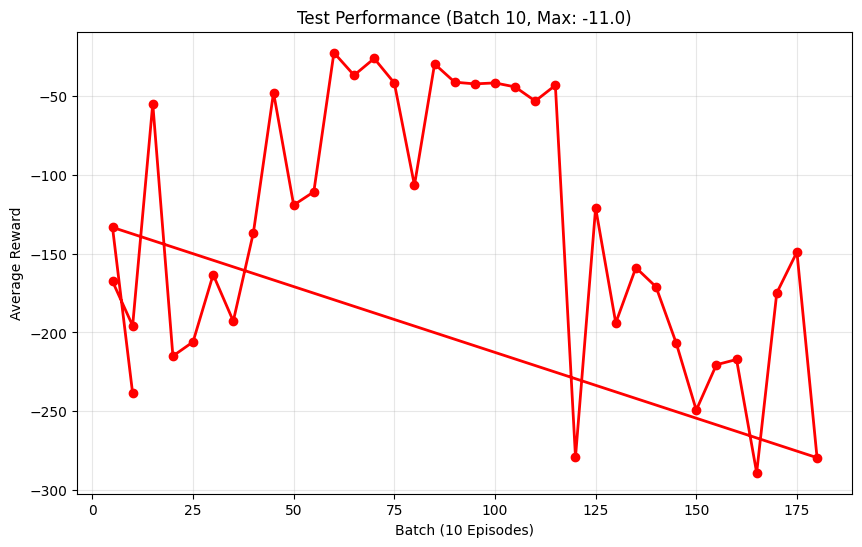

  1%|          | 12/1000 [01:55<2:42:14,  9.85s/it]

Training Batch 12: Collected 237 timesteps Episode Count: 20


  1%|▏         | 13/1000 [02:01<2:24:24,  8.78s/it]

Training Batch 13: Collected 144 timesteps Episode Count: 20
Training Batch 14: Collected 219 timesteps Episode Count: 20


  2%|▏         | 15/1000 [02:18<2:20:59,  8.59s/it]

Training Batch 15: Collected 213 timesteps Episode Count: 20
Training Batch 16: Collected 188 timesteps Episode Count: 20


  2%|▏         | 16/1000 [02:28<2:28:45,  9.07s/it]

Episode 15: Avg Test Reward = -176.87, Max Test Reward = -14.74
Training Batch 17: Collected 179 timesteps Episode Count: 20


  2%|▏         | 18/1000 [02:42<2:12:48,  8.11s/it]

Training Batch 18: Collected 190 timesteps Episode Count: 20


  2%|▏         | 19/1000 [02:52<2:17:41,  8.42s/it]

Training Batch 19: Collected 224 timesteps Episode Count: 20


  2%|▏         | 20/1000 [02:58<2:08:23,  7.86s/it]

Training Batch 20: Collected 182 timesteps Episode Count: 20
Training Batch 21: Collected 203 timesteps Episode Count: 20


Episode 20: Avg Test Reward = -138.89, Max Test Reward = -14.74


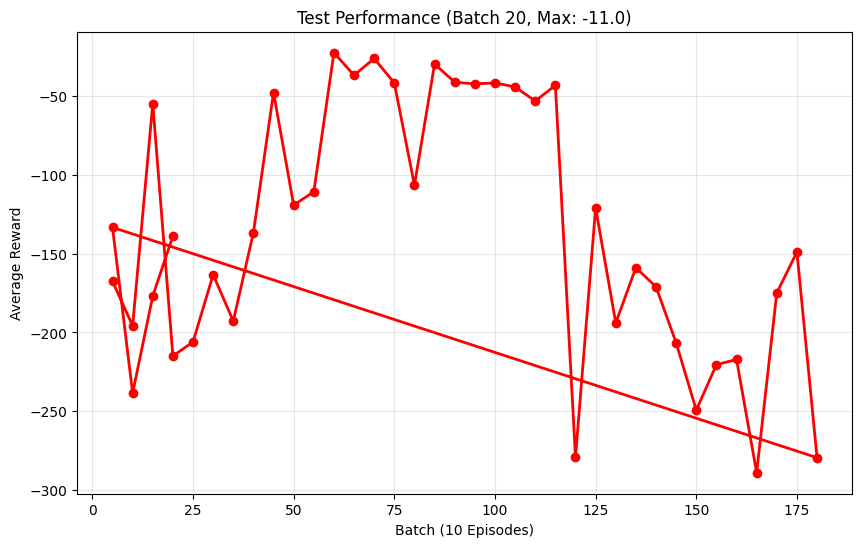

  2%|▏         | 22/1000 [03:16<2:15:39,  8.32s/it]

Training Batch 22: Collected 169 timesteps Episode Count: 20
Training Batch 23: Collected 235 timesteps Episode Count: 20


  2%|▏         | 24/1000 [03:31<2:04:16,  7.64s/it]

Training Batch 24: Collected 144 timesteps Episode Count: 20


  2%|▎         | 25/1000 [03:40<2:10:41,  8.04s/it]

Training Batch 25: Collected 212 timesteps Episode Count: 20
Training Batch 26: Collected 210 timesteps Episode Count: 20


  3%|▎         | 26/1000 [03:52<2:27:40,  9.10s/it]

Episode 25: Avg Test Reward = -210.59, Max Test Reward = -14.74


  3%|▎         | 27/1000 [03:57<2:11:46,  8.13s/it]

Training Batch 27: Collected 157 timesteps Episode Count: 20


  3%|▎         | 28/1000 [04:05<2:07:38,  7.88s/it]

Training Batch 28: Collected 172 timesteps Episode Count: 20


  3%|▎         | 29/1000 [04:12<2:06:59,  7.85s/it]

Training Batch 29: Collected 213 timesteps Episode Count: 20


  3%|▎         | 30/1000 [04:19<1:58:17,  7.32s/it]

Training Batch 30: Collected 135 timesteps Episode Count: 20
Training Batch 31: Collected 141 timesteps Episode Count: 20


Episode 30: Avg Test Reward = -186.49, Max Test Reward = -14.73


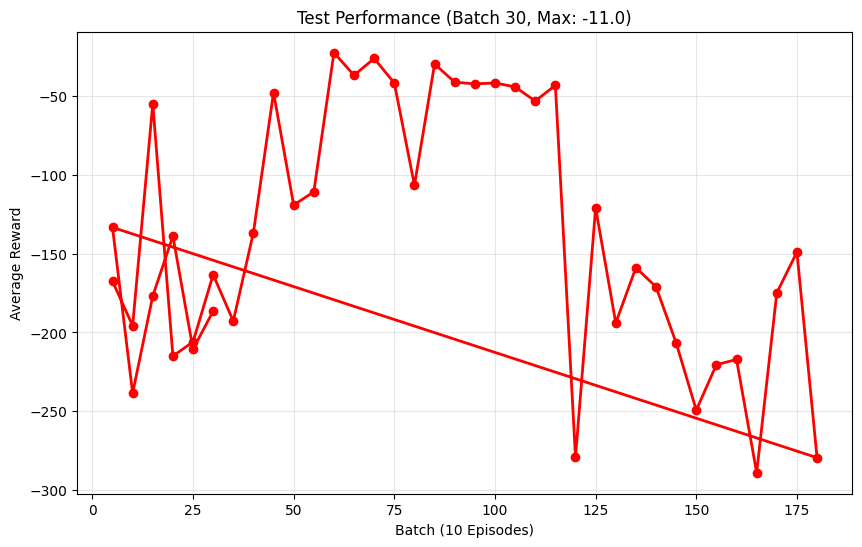

  3%|▎         | 32/1000 [04:34<1:59:17,  7.39s/it]

Training Batch 32: Collected 170 timesteps Episode Count: 20


  3%|▎         | 33/1000 [04:41<1:58:06,  7.33s/it]

Training Batch 33: Collected 169 timesteps Episode Count: 20
Training Batch 34: Collected 213 timesteps Episode Count: 20


  4%|▎         | 35/1000 [04:59<2:11:00,  8.15s/it]

Training Batch 35: Collected 193 timesteps Episode Count: 20
Training Batch 36: Collected 211 timesteps Episode Count: 20


  4%|▎         | 36/1000 [05:12<2:33:35,  9.56s/it]

Episode 35: Avg Test Reward = -195.81, Max Test Reward = -14.74


  4%|▎         | 37/1000 [05:22<2:34:00,  9.60s/it]

Training Batch 37: Collected 239 timesteps Episode Count: 20


  4%|▍         | 38/1000 [05:33<2:40:28, 10.01s/it]

Training Batch 38: Collected 218 timesteps Episode Count: 20
Training Batch 39: Collected 223 timesteps Episode Count: 20


  4%|▍         | 40/1000 [05:50<2:29:32,  9.35s/it]

Training Batch 40: Collected 234 timesteps Episode Count: 20
Training Batch 41: Collected 247 timesteps Episode Count: 20


Episode 40: Avg Test Reward = -194.06, Max Test Reward = -14.74


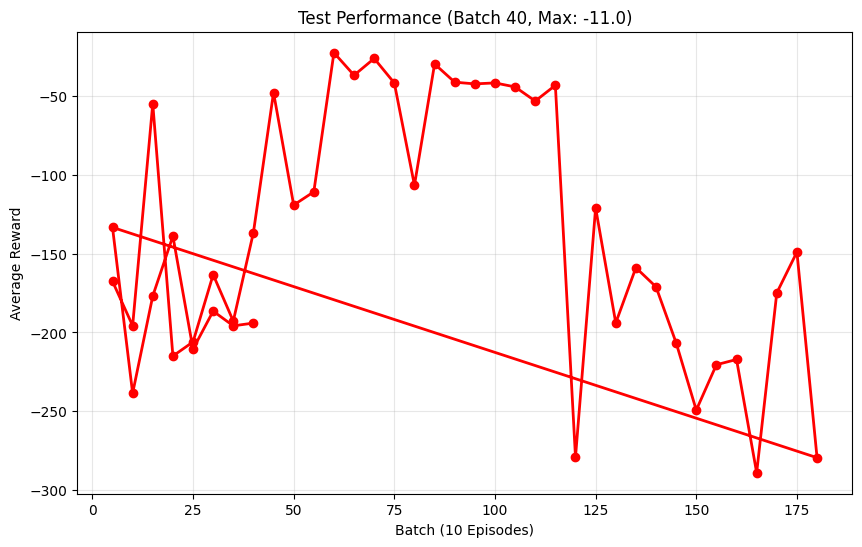

  4%|▍         | 42/1000 [06:13<2:44:55, 10.33s/it]

Training Batch 42: Collected 210 timesteps Episode Count: 20


  4%|▍         | 43/1000 [06:23<2:41:20, 10.12s/it]

Training Batch 43: Collected 238 timesteps Episode Count: 20
Training Batch 44: Collected 267 timesteps Episode Count: 20


  4%|▍         | 44/1000 [06:33<2:44:27, 10.32s/it]

Training Batch 45: Collected 294 timesteps Episode Count: 20


  4%|▍         | 45/1000 [06:45<2:50:30, 10.71s/it]

Training Batch 46: Collected 280 timesteps Episode Count: 20


  5%|▍         | 46/1000 [06:59<3:05:33, 11.67s/it]

Episode 45: Avg Test Reward = -164.25, Max Test Reward = -14.74


  5%|▍         | 47/1000 [07:07<2:48:57, 10.64s/it]

Training Batch 47: Collected 227 timesteps Episode Count: 20


  5%|▍         | 48/1000 [07:16<2:41:46, 10.20s/it]

Training Batch 48: Collected 221 timesteps Episode Count: 20
Training Batch 49: Collected 276 timesteps Episode Count: 20


  5%|▌         | 50/1000 [07:36<2:34:19,  9.75s/it]

Training Batch 50: Collected 176 timesteps Episode Count: 20
Training Batch 51: Collected 236 timesteps Episode Count: 20


In [ ]:
# Training loop
for batch in tqdm.tqdm(range(nb_batches)):

    # PPO Initialization
    advantages = torch.zeros(max_timesteps_per_rollout*rollout_size, dtype=torch.float32, device=device)
    buffer_states = torch.zeros((max_timesteps_per_rollout*rollout_size, state_dim), dtype=torch.float32, device=device)
    buffer_actions = torch.zeros((max_timesteps_per_rollout*rollout_size, action_dim), dtype=torch.float32, device=device)
    buffer_log_probs = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_state_values = torch.zeros((max_timesteps_per_rollout*rollout_size+1), dtype=torch.float32, device=device)
    buffer_rewards = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_is_terminal = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)

    # Env Initialization
    obs, _ = env.reset()
    state_manager.update(obs)

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Episode Reset
    obs, _ = env.reset()
    state_manager.update(obs)
    done = False
    obs_old = obs
    episode_step = 0
    episode_return = 0.0
    t = 0
    rollout = 0

    while not done and rollout < rollout_size:
      gap_control = Gap_Controller(obs, following_gap_threshold=30)
      activated_target_lane = gap_control.lane_checker()

      # Determine target lane
      target_id = activated_target_lane
      agent_state = state_manager.ego_state_agent(target_id=target_id)

      # Convert agent state dict to tensor
      state_tensor = torch.tensor(
          [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32, device=device
      ).unsqueeze(0)

      # Get action and value from model
      with torch.no_grad():
          agent_action, log_prob, value = model.action(state_tensor)
          action = state_manager.action(obs,agent_action)

      # Take action in environment
      obs, reward, done, truncated, info = env.step(action)
      done = done or truncated

      # Terminal conditions
      if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
          done = True

      # Update state manager with new observation and applied longitudinal control
      state_manager.update(obs)

      # Compute reward based on the new state
      reward_components = state_manager.reward_function(obs_old, obs, target_id)
      reward = reward_components[0]

      # Store trajectory information
      buffer_states[t] = state_tensor.squeeze(0)
      buffer_actions[t] = agent_action
      buffer_log_probs[t] = log_prob
      buffer_state_values[t] = value
      buffer_rewards[t] = torch.tensor(reward, dtype=torch.float32, device=device)
      buffer_is_terminal[t] = done

      t += 1  # Increment timestep counter
      obs_old = obs

      # If episode is done, increment rollout and reset for next episode
      if done:
          rollout += 1
          if rollout < rollout_size:
              obs, _ = env.reset()
              state_manager.update(obs)
              done = False
              obs_old = obs

    # Print rollout info
    print(f"Training Batch {batch+1}: Collected {t} timesteps Episode Count: {rollout}")

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(t, dtype=torch.float32, device=device)

    for t_idx in range(t-1, -1, -1):
        if buffer_is_terminal[t_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if t_idx == t-1:
                next_value = 0
            else:
                next_value = buffer_state_values[t_idx+1]

        delta = buffer_rewards[t_idx] + gamma * next_value * (1-terminal) - buffer_state_values[t_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[t_idx] = gae

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            buffer_states[:t].detach(),
            buffer_actions[:t].detach(),
            buffer_log_probs[:t].detach(),
            buffer_state_values[:t].detach()),
        batch_size=min(batch_size, t),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            dist, value = model(obs_batch)
            log_probs = dist.log_prob(action_batch)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)
            returns = b_adv + old_state_values

            # Policy loss
            policy_loss_1 = b_adv * ratio
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-epsilon, 1+epsilon)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            actor_loss = policy_loss - ent_coef_c2 * dist.entropy().mean()
            critic_loss = F.mse_loss(value.squeeze(),returns)

            # Optimize
            # For the actor:
            actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(actor_params, max_norm=0.5)  # ADD THIS LINE
            actor_optimizer.step()

            # For the critic:
            critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic_params, max_norm=0.5)  # ADD THIS LINE
            critic_optimizer.step()

    # Testing every 5 batches
    if batch % test_rate == 0 and batch > 0:
        num_test = 1
        test_rewards = []
        frames = []
        time = []
        state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)


        for test_ep in range(10):  # 10 test episodes
            obs, _ = env.reset()
            obs_old = obs
            episode_reward = 0
            done = False
            test_steps = 0
            state_manager.update(obs)

            while not done and test_steps < 500:  # Limit test episode
                gap_control = Gap_Controller(obs, following_gap_threshold=30)
                activated_target_lane = gap_control.lane_checker()

                # Determine target lane
                target_id = activated_target_lane
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    agent_action, log_prob, value = model.action(state_tensor,deterministic=True)

                action = state_manager.action(obs, agent_action)

                obs, _, done, truncated, info = env.step(action)
                done = done or truncated

                if test_ep % 5 == 0:
                    image = env.render()
                    frames.append(image)

                # Terminal conditions
                if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
                    done = True

                state_manager.update(obs)
                reward_components = state_manager.reward_function(obs_old, obs, target_id)
                reward = reward_components[0]

                episode_reward += reward
                test_steps += 1
                obs_old = obs

            test_rewards.append(episode_reward)

        # This will definitely show in Colab:
        display(animate_image_list_efficient(frames))

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(batch)
        print(f"Episode {batch}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 50 btaches
    if batch % 10 == 0 and batch > 0 and len(batch_average_reward_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
        plt.title(f"Test Performance (Batch {batch}, Max: {max_reward:.1f})")
        plt.xlabel("Batch (10 Episodes)")
        plt.ylabel("Average Reward")
        plt.grid(True, alpha=0.3)
        plt.show()

print("Training completed!")